# Testing Naive Batch Learning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ! mkdir /content/drive/MyDrive/wordle-rl/tests

In [3]:
! cp -a -n /content/drive/MyDrive/wordle-rl/. /content/

In [4]:
! pip install cpprb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 63.2 MB/s eta 0:00:00


In [1]:
%load_ext autoreload
%autoreload 2

from functools import partial
from collections import defaultdict
import pickle

from wordle.wordlenp import Wordle
from environment.environment import Environment, StateYesNo, StateVocabulary, ActionVocabulary
from dqn.agent import Agent
from dqn.train import Trainer
from replay_buffer.cpprb import PrioritizedReplayBuffer, ReplayBuffer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import torch
import numpy as np
np.random.seed(0)

## Датасеты

In [2]:
word_list = Wordle._load_vocabulary('wordle/guesses.txt', astype=np.array)

def make_data(n_answers, n_guesses):
    guesses = np.random.choice(word_list, size=n_guesses, replace=False)
    answers = np.random.choice(guesses, size=n_answers, replace=False)
    return answers, guesses

### 10 answers, 100 guesses

In [3]:
answers_10_100, guesses_10_100 = make_data(10, 100)
print(answers_10_100)

['abmho' 'cites' 'aware' 'blays' 'acker' 'rawin' 'anile' 'eorls' 'feers'
 'sadza']


### 100 answers, 100 guesses

In [4]:
answers_100_100, guesses_100_100 = make_data(100, 100)
print(answers_100_100)

['lilac' 'orles' 'twirl' 'unled' 'sings' 'grind' 'sheaf' 'benny' 'slews'
 'karst' 'rimus' 'lossy' 'joker' 'leash' 'scopa' 'viols' 'giron' 'raiks'
 'lummy' 'renig' 'tinds' 'infos' 'logon' 'drill' 'gudes' 'ammon' 'bhoot'
 'hurry' 'noils' 'coven' 'beryl' 'margs' 'sorbo' 'momes' 'scald' 'potch'
 'flows' 'torus' 'prill' 'scuts' 'brith' 'tamin' 'sewar' 'joram' 'aldol'
 'hazel' 'texes' 'sibbs' 'truth' 'spoil' 'hames' 'actin' 'maces' 'rayas'
 'thuya' 'sugan' 'felly' 'newsy' 'bolos' 'mimeo' 'chems' 'dicty' 'liefs'
 'scuff' 'burps' 'abyes' 'zones' 'cuspy' 'kerve' 'haith' 'amino' 'zygal'
 'kokum' 'zambo' 'icier' 'piers' 'sambo' 'laden' 'barge' 'solei' 'mauts'
 'groat' 'pearl' 'curse' 'jujus' 'troop' 'bilge' 'sibyl' 'gassy' 'elain'
 'daube' 'feyly' 'duals' 'hoper' 'hains' 'beige' 'poove' 'miffy' 'lesbo'
 'dawds']


### 50 answers, 200 guesses

In [5]:
answers_50_200, guesses_50_200 = make_data(50, 200)
print(answers_50_200)

['toran' 'burka' 'umpie' 'brock' 'civic' 'beige' 'hoiks' 'biffo' 'nagas'
 'sheol' 'malls' 'matzo' 'peeve' 'deshi' 'mooli' 'scaud' 'ameba' 'wadds'
 'bayts' 'glees' 'kaput' 'bitos' 'comae' 'dosed' 'rabis' 'neats' 'tutti'
 'stays' 'smoky' 'chase' 'resaw' 'simas' 'sowne' 'rorid' 'rebec' 'deawy'
 'hinny' 'sores' 'cerge' 'yogas' 'fouet' 'wheel' 'sowfs' 'talus' 'yabas'
 'topee' 'sabin' 'unbox' 'dyers' 'qophs']


### 300 answers, 300 guesses

In [6]:
answers_300_300, guesses_300_300 = make_data(300, 300)
print(answers_300_300)

['hoied' 'aarti' 'dyers' 'ingot' 'hasty' 'tices' 'tache' 'deoxy' 'sutta'
 'score' 'fiefs' 'sling' 'ready' 'wests' 'dobes' 'tells' 'bitts' 'roper'
 'veena' 'hewer' 'chats' 'jarta' 'ceric' 'olent' 'feare' 'bodge' 'fleer'
 'prats' 'spiny' 'tryps' 'welts' 'march' 'jelly' 'furor' 'okapi' 'penni'
 'curve' 'altar' 'aboon' 'salut' 'amido' 'razor' 'vouch' 'prill' 'ganev'
 'dukka' 'noxal' 'briar' 'wills' 'trigo' 'dusts' 'meter' 'veale' 'hafiz'
 'dosha' 'wilis' 'ohmic' 'silds' 'giust' 'blimy' 'zerda' 'mucus' 'abrin'
 'nandu' 'larva' 'cruds' 'kaies' 'hussy' 'dolce' 'birch' 'madam' 'chase'
 'onely' 'molys' 'scape' 'sauce' 'amate' 'mohur' 'vagal' 'royne' 'spics'
 'azuki' 'acres' 'shops' 'sicks' 'sunup' 'cosey' 'louse' 'aweel' 'skosh'
 'twoer' 'loves' 'wents' 'reest' 'winna' 'rosed' 'mbira' 'rangy' 'omega'
 'moira' 'typey' 'romal' 'bachs' 'floss' 'scath' 'roast' 'moola' 'moles'
 'witch' 'rabbi' 'chest' 'aulos' 'yokes' 'aspen' 'sepic' 'lirot' 'lemon'
 'musts' 'drouk' 'kudzu' 'yacka' 'sonny' 'hived' 'l

### 100 answers, 2000 guesses

In [7]:
answers_100_2000, guesses_100_2000 = make_data(100, 2000)
print(answers_100_2000)

['fumed' 'rival' 'zizit' 'wests' 'scrog' 'gryce' 'seils' 'sugar' 'glims'
 'pharm' 'pyets' 'kilts' 'bings' 'emyde' 'duads' 'shahs' 'spaza' 'spore'
 'redub' 'sidas' 'choco' 'woofs' 'sukuk' 'spumy' 'mirex' 'sluse' 'tween'
 'nodus' 'wands' 'unled' 'rates' 'toxin' 'lotes' 'wacko' 'ariot' 'baisa'
 'sways' 'roads' 'poked' 'popsy' 'gonif' 'vutty' 'bicep' 'parky' 'braid'
 'ports' 'spyal' 'match' 'spook' 'scowp' 'sdein' 'lovie' 'torii' 'souks'
 'vibey' 'genny' 'clues' 'decaf' 'diced' 'delay' 'mirly' 'flogs' 'lotos'
 'whine' 'seems' 'jerry' 'scram' 'gosse' 'roped' 'pipis' 'spank' 'seder'
 'doorn' 'evict' 'buteo' 'ponks' 'miffy' 'potin' 'rathe' 'papaw' 'local'
 'tolus' 'apode' 'jouks' 'decad' 'temes' 'wafts' 'liter' 'kagos' 'piste'
 'ogmic' 'fyles' 'brace' 'adage' 'hepar' 'bales' 'molal' 'eject' 'seles'
 'commy']


## Plotting Utility

In [8]:
def plot_results(tasks_results, figname):
    n_tasks = len(tasks_results)
    _, ax = plt.subplots(1, n_tasks, figsize=(4*n_tasks, 5))
    
    color = ['b','g','r','c','m','y','k','w']

    # over tasks
    for i, (task_name, results) in enumerate(tasks_results.items()):
        # over methods
        for c, (method_name, res) in enumerate(results.items()):
            train_timers, train_win_rates, test_timers, test_win_rates = res
            ax[i].plot(train_timers, train_win_rates, label=method_name+' (train)', c=color[c], alpha=0.2)
            ax[i].plot(test_timers, test_win_rates, label=method_name+' (test)', c=color[c])
        ax[i].set_xlabel('time, s')
        ax[i].set_ylabel('win rate, s')
        ax[i].legend()
        ax[i].set_title(task_name)
    plt.savefig(figname + '.svg', bbox_inches='tight')
    plt.show()

## Sampling

In [9]:
soft_rewards = {'B':1, 'Y':2, 'G':3, 'win':20, 'lose':-10, 'step':-4}
hard_rewards = {'B':0, 'Y':0, 'G':0, 'win':10, 'lose':-10, 'step':-2}
step_rewards = {'B':0, 'Y':1, 'G':1, 'win':10, 'lose':-10, 'step':-5}
char_rewards = {'B':0, 'Y':1, 'G':1, 'win':10, 'lose':-10, 'step':-2}

In [10]:
tasks_results = defaultdict(dict)

### Uniform

In [22]:
def experiment(answers, guesses, n_batches, n_batches_warm):
    env = Environment(
        rewards=step_rewards,
        wordle=Wordle(vocabulary=guesses, answers=answers),
        state_instance=StateYesNo()
    )

    agent = Agent(
        state_size=env.state.size,
        action_size=len(guesses),
        action_constructor=partial(ActionVocabulary, vocabulary=guesses),
        # here is what we are experimenting with
        replay_buffer=ReplayBuffer(state_size=env.state.size, n_step=6, gamma=1),
    )

    trainer = Trainer(
        env, agent,
        play_batch_size=64, n_batches=n_batches,
        n_batches_warm=n_batches_warm
    )
    
    res = trainer.train(eps_decay=0.997, nickname=f'uniform-{len(answers)}-{len(guesses)}')
    return res

In [23]:
res = experiment(
    answers_10_100, guesses_10_100,
    n_batches=500, n_batches_warm=15,
)

tasks_results['10/100']['uniform'] = res


Batch   62	Time: 18 s	Agent Eps: 0.83	Train Win Rate: 25.81%	Test Win Rate: 60.00%	Test Mean Steps: 2.83

Batch  124	Time: 36 s	Agent Eps: 0.69	Train Win Rate: 67.74%	Test Win Rate: 100.00%	Test Mean Steps: 2.30

Batch  186	Time: 55 s	Agent Eps: 0.57	Train Win Rate: 91.94%	Test Win Rate: 100.00%	Test Mean Steps: 2.10

Batch  248	Time: 73 s	Agent Eps: 0.47	Train Win Rate: 93.55%	Test Win Rate: 100.00%	Test Mean Steps: 2.00


KeyboardInterrupt: 

In [24]:
res = experiment(
    answers_100_100, guesses_100_100,
    n_batches=2500, n_batches_warm=10,
)

tasks_results['100/100']['uniform'] = res

KeyboardInterrupt: 

In [18]:
# with open('sampling.pickle', 'wb') as handle:
#     pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests

In [19]:
res = experiment(
    answers_300_300, guesses_300_300,
    n_batches=4000, n_batches_warm=10,
)
tasks_results['300/300']['uniform'] = res


Batch  500	Time: 60 s	RMSE: 13.6193	Agent Eps: 0.22	Train Score: -28.48	Train Win Rate: 7.60%	Test Score: -28.13	Test Win Rate: 8.00%	Test Mean Steps: 3.46

Batch 1000	Time: 125 s	RMSE: 15.4936	Agent Eps: 0.05	Train Score: -26.01	Train Win Rate: 15.00%	Test Score: -26.29	Test Win Rate: 14.33%	Test Mean Steps: 3.91

Batch 1500	Time: 190 s	RMSE: 25.1302	Agent Eps: 0.05	Train Score: -25.18	Train Win Rate: 18.00%	Test Score: -24.53	Test Win Rate: 19.00%	Test Mean Steps: 3.68

Batch 2000	Time: 264 s	RMSE: 30.2097	Agent Eps: 0.05	Train Score: -23.95	Train Win Rate: 22.00%	Test Score: -22.99	Test Win Rate: 24.33%	Test Mean Steps: 3.79

Batch 2500	Time: 329 s	RMSE: 27.8590	Agent Eps: 0.05	Train Score: -19.84	Train Win Rate: 34.80%	Test Score: -21.22	Test Win Rate: 30.67%	Test Mean Steps: 3.96

Batch 3000	Time: 395 s	RMSE: 22.4655	Agent Eps: 0.05	Train Score: -18.28	Train Win Rate: 40.40%	Test Score: -17.77	Test Win Rate: 42.33%	Test Mean Steps: 3.91

Batch 3500	Time: 460 s	RMSE: 26.7189	Agent

In [20]:
# with open('sampling.pickle', 'wb') as handle:
#     pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

In [21]:
res = experiment(
    answers_100_2000, guesses_100_2000,
    n_batches=4000, n_batches_warm=15,
)
tasks_results['100/2000']['uniform'] = res


Batch  500	Time: 62 s	RMSE: 10.7457	Agent Eps: 0.22	Train Score: -30.46	Train Win Rate: 2.60%	Test Score: -31.20	Test Win Rate: 3.00%	Test Mean Steps: 2.00

Batch 1000	Time: 128 s	RMSE: 18.5802	Agent Eps: 0.05	Train Score: -28.28	Train Win Rate: 9.40%	Test Score: -28.83	Test Win Rate: 7.00%	Test Mean Steps: 3.71

Batch 1500	Time: 194 s	RMSE: 15.4048	Agent Eps: 0.05	Train Score: -28.48	Train Win Rate: 8.60%	Test Score: -27.83	Test Win Rate: 10.00%	Test Mean Steps: 3.50

Batch 2000	Time: 261 s	RMSE: 21.1397	Agent Eps: 0.05	Train Score: -25.67	Train Win Rate: 17.40%	Test Score: -25.37	Test Win Rate: 18.00%	Test Mean Steps: 3.44

Batch 2500	Time: 328 s	RMSE: 31.3856	Agent Eps: 0.05	Train Score: -24.35	Train Win Rate: 21.40%	Test Score: -24.64	Test Win Rate: 20.00%	Test Mean Steps: 3.65

Batch 3000	Time: 394 s	RMSE: 36.3910	Agent Eps: 0.05	Train Score: -23.38	Train Win Rate: 24.60%	Test Score: -22.04	Test Win Rate: 27.00%	Test Mean Steps: 3.30

Batch 3500	Time: 462 s	RMSE: 35.9539	Agent Ep

In [22]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

### A Little Prioritized

In [27]:
def experiment(answers, guesses, n_batches, n_batches_warm):
    env = Environment(
        rewards=step_rewards,
        wordle=Wordle(vocabulary=guesses, answers=answers),
        state_instance=StateYesNo()
    )

    agent = Agent(
        state_size=env.state.size,
        action_size=len(guesses),
        action_constructor=partial(ActionVocabulary, vocabulary=guesses),
        # here is what we are experimenting with
        replay_buffer=PrioritizedReplayBuffer(
            state_size=env.state.size,
            alpha=0.1, beta=1, beta_growth_rate=1,
        )
    )

    trainer = Trainer(
        env, agent,
        play_batch_size=64, n_batches=n_batches,
        n_batches_warm=n_batches_warm
    )
    
    res = trainer.train(eps_decay=0.997, nickname=f'little-{len(answers)}-{len(guesses)}')
    return res

In [28]:
res = experiment(
    answers_10_100, guesses_10_100,
    n_batches=500, n_batches_warm=15,
)

tasks_results['10/100']['little'] = res


Batch   62	Time: 9 s	RMSE: 145.4799	Agent Eps: 0.83	Train Score: -17.44	Train Win Rate: 46.77%	Test Score: -2.70	Test Win Rate: 80.00%	Test Mean Steps: 2.62

Batch  124	Time: 16 s	RMSE: 112.6447	Agent Eps: 0.69	Train Score: -11.31	Train Win Rate: 66.13%	Test Score: 2.90	Test Win Rate: 90.00%	Test Mean Steps: 2.22

Batch  186	Time: 23 s	RMSE: 164.5391	Agent Eps: 0.57	Train Score: -3.85	Train Win Rate: 82.26%	Test Score: 7.10	Test Win Rate: 100.00%	Test Mean Steps: 2.10

Batch  248	Time: 31 s	RMSE: 103.5868	Agent Eps: 0.47	Train Score: 0.53	Train Win Rate: 93.55%	Test Score: 7.50	Test Win Rate: 100.00%	Test Mean Steps: 2.00

Batch  310	Time: 38 s	RMSE: 111.1097	Agent Eps: 0.39	Train Score: -1.42	Train Win Rate: 90.32%	Test Score: 7.50	Test Win Rate: 100.00%	Test Mean Steps: 2.00

Batch  372	Time: 46 s	RMSE: 99.0281	Agent Eps: 0.33	Train Score: 3.19	Train Win Rate: 100.00%	Test Score: 7.50	Test Win Rate: 100.00%	Test Mean Steps: 2.00

Batch  434	Time: 54 s	RMSE: 66.3727	Agent Eps: 0.27	T

In [29]:
res = experiment(
    answers_100_100, guesses_100_100,
    n_batches=2500, n_batches_warm=15,
)

tasks_results['100/100']['little'] = res


Batch  312	Time: 39 s	RMSE: 195.1631	Agent Eps: 0.39	Train Score: -23.56	Train Win Rate: 25.32%	Test Score: -19.10	Test Win Rate: 36.00%	Test Mean Steps: 3.42

Batch  624	Time: 81 s	RMSE: 214.6835	Agent Eps: 0.15	Train Score: -12.91	Train Win Rate: 58.33%	Test Score: -11.78	Test Win Rate: 60.00%	Test Mean Steps: 3.43

Batch  936	Time: 124 s	RMSE: 219.4904	Agent Eps: 0.06	Train Score: -3.85	Train Win Rate: 82.05%	Test Score: -2.28	Test Win Rate: 85.00%	Test Mean Steps: 3.05

Batch 1248	Time: 166 s	RMSE: 186.2187	Agent Eps: 0.05	Train Score: 2.56	Train Win Rate: 97.76%	Test Score: 2.14	Test Win Rate: 95.00%	Test Mean Steps: 2.79

Batch 1560	Time: 209 s	RMSE: 163.3046	Agent Eps: 0.05	Train Score: 1.49	Train Win Rate: 95.83%	Test Score: 3.75	Test Win Rate: 99.00%	Test Mean Steps: 2.75

Batch 1872	Time: 250 s	RMSE: 131.8675	Agent Eps: 0.05	Train Score: 2.99	Train Win Rate: 97.44%	Test Score: 3.87	Test Win Rate: 98.00%	Test Mean Steps: 2.63

Batch 2184	Time: 292 s	RMSE: 128.7380	Agent Eps: 

In [31]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

In [32]:
res = experiment(
    answers_300_300, guesses_300_300,
    n_batches=4000, n_batches_warm=15,
)
tasks_results['300/300']['little'] = res


Batch  500	Time: 72 s	RMSE: 103.1625	Agent Eps: 0.22	Train Score: -28.74	Train Win Rate: 6.60%	Test Score: -28.65	Test Win Rate: 7.00%	Test Mean Steps: 4.29

Batch 1000	Time: 140 s	RMSE: 138.1599	Agent Eps: 0.05	Train Score: -26.91	Train Win Rate: 12.00%	Test Score: -26.91	Test Win Rate: 12.00%	Test Mean Steps: 3.81

Batch 1500	Time: 209 s	RMSE: 166.2006	Agent Eps: 0.05	Train Score: -25.59	Train Win Rate: 16.60%	Test Score: -24.28	Test Win Rate: 20.33%	Test Mean Steps: 3.82

Batch 2000	Time: 279 s	RMSE: 184.2904	Agent Eps: 0.05	Train Score: -23.44	Train Win Rate: 23.40%	Test Score: -22.35	Test Win Rate: 27.33%	Test Mean Steps: 4.07

Batch 2500	Time: 349 s	RMSE: 158.3917	Agent Eps: 0.05	Train Score: -20.67	Train Win Rate: 32.00%	Test Score: -19.69	Test Win Rate: 35.33%	Test Mean Steps: 3.78

Batch 3000	Time: 418 s	RMSE: 220.2719	Agent Eps: 0.05	Train Score: -19.11	Train Win Rate: 39.20%	Test Score: -21.63	Test Win Rate: 32.33%	Test Mean Steps: 4.35

Batch 3500	Time: 487 s	RMSE: 230.084

In [33]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

In [34]:
res = experiment(
    answers_100_2000, guesses_100_2000,
    n_batches=4000, n_batches_warm=15,
)
tasks_results['100/2000']['little'] = res


Batch  500	Time: 65 s	RMSE: 154.9065	Agent Eps: 0.22	Train Score: -29.50	Train Win Rate: 5.80%	Test Score: -29.92	Test Win Rate: 5.00%	Test Mean Steps: 3.00

Batch 1000	Time: 133 s	RMSE: 197.7435	Agent Eps: 0.05	Train Score: -27.59	Train Win Rate: 11.40%	Test Score: -27.92	Test Win Rate: 10.00%	Test Mean Steps: 3.70

Batch 1500	Time: 202 s	RMSE: 276.8283	Agent Eps: 0.05	Train Score: -26.49	Train Win Rate: 14.00%	Test Score: -25.12	Test Win Rate: 18.00%	Test Mean Steps: 3.39

Batch 2000	Time: 272 s	RMSE: 187.9471	Agent Eps: 0.05	Train Score: -24.56	Train Win Rate: 20.40%	Test Score: -25.39	Test Win Rate: 18.00%	Test Mean Steps: 3.50

Batch 2500	Time: 341 s	RMSE: 223.9631	Agent Eps: 0.05	Train Score: -24.97	Train Win Rate: 19.40%	Test Score: -23.66	Test Win Rate: 22.00%	Test Mean Steps: 3.45

Batch 3000	Time: 410 s	RMSE: 208.1917	Agent Eps: 0.05	Train Score: -23.10	Train Win Rate: 25.40%	Test Score: -22.54	Test Win Rate: 27.00%	Test Mean Steps: 3.78

Batch 3500	Time: 480 s	RMSE: 207.571

In [36]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

### Plot Results

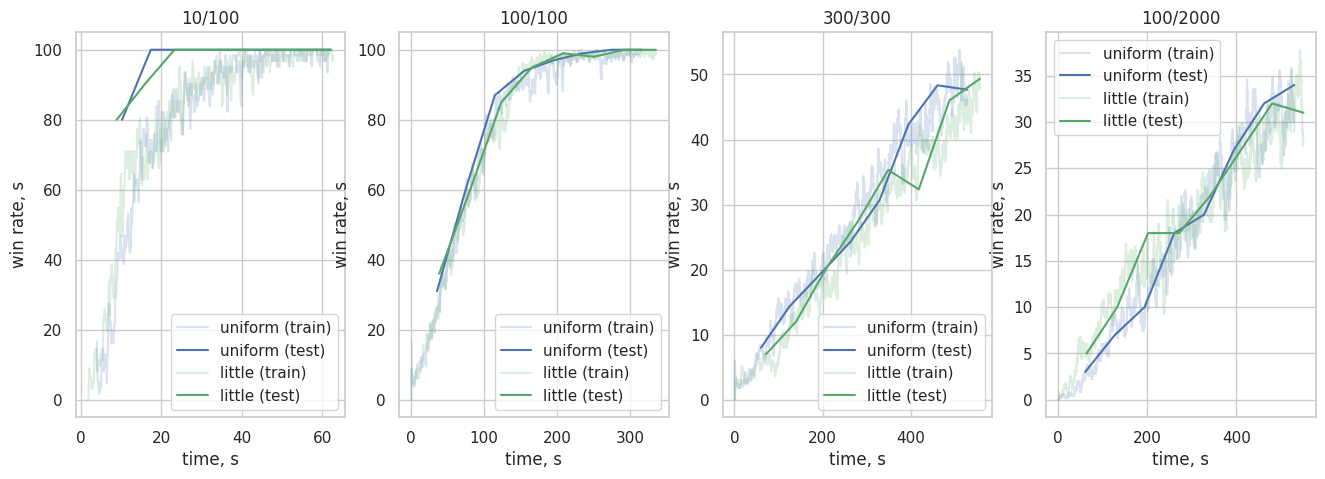

In [39]:
plot_results(tasks_results, 'sampling')